# 太阳能板阵列计算框架

## 函数定义总览
接下来定义各种函数，最终输出一个函数`eff_panel`, 描述一个太阳能接收板某一时刻的输出功率。
输入:
- 以接受塔为中心的横纵坐标(x,y)
- 太阳相对阵列的高度角$\alpha_s$, 方位角$\gamma_s$
- 太阳能接收板的面积$A$
- 太阳能接收板到接受塔的水平距离$d$, 太阳能接收板和接受塔的高度$h1, h2$
- 海拔高度$H$

输出:
- 太阳能接收板的输出功率$E_{field}$

## 符号定义
- $A$: 太阳能接收板的面积
- $d$: 太阳能接收板到接受塔的水平距离
- $h1, h2$: 太阳能接收板和接受塔的高度
- $H$: 海拔高度
- $x, y$: 以接受塔为中心的横纵坐标
- $\alpha_s$: 太阳相对阵列的高度角
- $\gamma_s$: 太阳相对阵列的方位角

- DNI: 太阳直射辐照度, 一个用于计算太阳能接收板输出功率的参数
- $\eta_{sb}$: 阴影遮挡下的效率. 考虑了太阳能板之间的阴影遮挡, 以及太阳能板的倾角和方位角对太阳能接收板的阴影遮挡的影响
- $\eta_{cos}$: 太阳能接收板的cosine效率, 考虑了太阳光入射角对太阳能接收板的影响
- $\eta_{at}$: 太阳能接收板的大气效率, 考虑了大气对太阳光的吸收和散射. 表达式为:
$$\eta_{at} = 0.99321-1.1176\times10^{-4}d_{HR}+1.97\times10^{-8}d_{HR}^2$$
其中$d_{HR}$为反射镜中心到集热器中心的距离, 单位为m.
- $\eta_{trunc}$: 太阳能接收板的截断效率, 考虑了太阳能接收板的边缘效应. 这部分损失是由于吸收器无法完全吸收反射光.
- $\eta_{ref}$: 镜面反射率. 考虑为常数, 取0.92.



## 函数数学表达式

### $DNI$ 与阵列无关
$$DNI = G_0[a+bexp(-\frac{c}{sin\alpha_s})]$$
其中$G_0$为太阳常数, $a, b, c$计算如下:
$$a = 0.4237 - 0.00821(6 - H)^2$$
$$b = 0.5055 + 0.00595(6.5 - H)^2$$
$$c = 0.2711 + 0.01858(2.5 - H)^2$$

### $E_{field}$ 与阵列有关
$$E_{field} = DNI \cdot \sum_{i=1}^{N}A_i\eta_{sb}\eta_{cos}\eta_{at}\eta_{trunc}\eta_{ref}$$
其中$A_i$为太阳能接收板的面积, $N$为太阳能接收板的数量.

### $\eta_{sb}$ 与阵列有关
计算$\eta_{sb}$会用到以下参数:
- 太阳方位$\gamma_s$, 太阳高度角$\alpha_s$
- 两个太阳能板的中心距离,记为$x_a, y_a, z_a$和$x_b, y_b, z_b$, 吸收塔的坐标记为$x_t, y_t, z_t$
- 太阳能板A的反射角$\theta_a$, 近似认为$\theta_a = \alpha_b$

首先计算以下值:
1. a,b板之间的距离向量$\vec{ab} = (x_b-x_a, y_b-y_a, z_b-z_a)$, 距离为$d_{ab} = \sqrt{(x_b-x_a)^2+(y_b-y_a)^2+(z_b-z_a)^2}$
2. 遮挡判断$\lambda = \vec{ab}\cdot\vec{ray}$, 其中$\vec{ray}$为入射光线或者反射光线的方向向量. 如果$\lambda<0$, 则a不可能被b遮挡.
3. 入射光线角度$-m =(cos\alpha_ssin\gamma_s, cos\alpha_scos\gamma_s, sin\alpha_s)$, 其中$\alpha_s$为太阳高度角, $\gamma_s$为太阳方位角, $-m$指向太阳.
4. 反射光线角度$n = (x_t-x_a, y_t-y_a, z_t-z_a)$, 其中$x_t, y_t, z_t$为吸收塔的坐标, $n$指向吸收塔.
5. 估计的倾斜视角的反射镜对角线长度$D_{approx}= \sqrt{(cos\theta_aW_{ref})^2+H_{ref}^2}$, 面积为$A_{approx} = H_{ref}W_{ref}cos\theta_a$

对于入射光线:
ab连线的投影:
$$D_{ab}' = \sqrt{d_{ab}^2-(\vec{ab}\cdot\vec{ray})^2}$$
最大阴影矩形区域对角线长度:
$$D_{PQ}=D_{approx}-D_{ab}'$$
最大阴影矩形区域面积:
$$A_{PQ} = \frac{D_{PQ}^2}{D_{approx}^2}A_{approx}$$
注意这里估计的阴影区域偏大,也许可以用0.5乘以这个值来估计.

对于反射光线:
ab连线的投影:
$$D_{ab}' = \sqrt{d_{ab}^2-(\vec{ab}\cdot\vec{ray})^2}$$
最大阴影矩形区域对角线长度:
$$D_{PQ}=D_{approx}-D_{ab}'$$
最大阴影矩形区域面积:
$$A_{PQ} = \frac{D_{PQ}^2}{D_{approx}^2}A_{approx}$$
注意这里估计的阴影区域偏大,也许可以用0.5乘以这个值来估计.

最后,假设阴影区域彼此不重叠, 则阴影遮挡效率为:
$$\eta_{sb} = 1-\sum_{邻近panel}^{}A_{PQ_i}/A_{approx}$$
### $\eta_{cos}$ 与阵列有关
$$\eta_{cos} = cos(\theta)$$
其中$\theta$为太阳光入射角, 计算如下:
$$cos\theta = \sqrt{\frac{1}{2}[1+\frac{1}{d_{HR}}(-xcos\alpha_ssin\gamma_s-ycos\alpha_s\cos\gamma_s+sin\alpha_s(h_1-h_2))]}$$
### $\eta_{at}$ 与阵列有关
$$\eta_{at} = 0.99321-1.1176\times10^{-4}d_{HR}+1.97\times10^{-8}d_{HR}^2$$
已经给定.
### $\eta_{trunc}$
集热器的截断效率为吸收的面积与集热器面积的比值。
$\eta_{trunc}=\frac{A_{吸收}}{A_{投射}}$
其中$A_{吸收}$为吸收的面积, $A_{投射}$为反光镜投射的光线面积.
$$A_{吸收}=\min(H_{HR},H_{ref}\cdot\frac{cos\theta_v}{cos\beta})\cdot \min(W_{HR},W_{ref}\cdot cos\theta_h)$$
其中$H_{HR}$为集热器高度, $W_{HR}$为集热器宽度, $H_{ref}$为反射镜高度, $W_{ref}$为反射镜宽度.
$$A_{投射}=H_{ref}\cdot \frac{cos\theta_v}{cos\beta}\times W_{ref}\cdot cos\theta_h$$
关于$\theta$,其余弦用二倍角公式计算:
$$cos\theta_v=\sqrt{\frac{1+cos2\theta_v}{2}}=\sqrt{\frac{1+cos(\alpha_s-\beta)}{2}}$$
$$cos\theta_h=\sqrt{\frac{1+cos2\theta_h}{2}}=-\frac{1}{\sqrt{x^2+y^2}}(xsin\gamma_s+ycos\gamma_s)$$
其中🤯$\gamma_s$为太阳的方位角,它的计算尚未解决,
$x,y$为以接受塔为中心的横纵坐标. $\sqrt{x^2+y^2}=d_{HR}$.
$\beta$为集热器中心对于反光镜的高度角, 其计算方式如下:
$$\beta=arctan(\frac{h_1-h_2}{d})$$
### $\eta_{ref}$ 与阵列有关
已经给定,常数.
### $d_{HR}$ 与阵列有关
$$d_{HR} = \sqrt{(x)^2+(y)^2+(h_1-h_2)^2}$$
直线距离.


## 功率计算
在模拟阵列的功率时,为简化模型,我们只是用五个时间点的功率值来估计一天的功率值. 五个时间点分别为:
9:00、10:30、12:00、13:30、15:00
在估计一年的功率时,我们使用每个月21日的功率值来估计该月的功率值.

### 数值计算任务
根据任务需求, 我们需要计算**12**天, 每天**5**个时间点的功率值, 包括这**12*5**个时间点的$\eta_{sb}$, $\eta_{cos}$, $\eta_{at}$, $\eta_{trunc}$的值.

## 阵列优化
### 优化目标
优化目标为: 使得阵列的单位面积平均功率最大.
主要约束条件为:
- 阵列的总面积不超过给定的面积
- 阵列的总功率需要超过给定的功率
- 还有吗?
次要约束条件为:
- 吸收塔周围150m范围内不能部署阵列
- 反射镜的高度不能超过镜面高度的一半
- 还有吗?

### 优化方法
> 以下是暂定方法

#### 超参数, 参数, 变量
在前面的问题中, 仅将阵列的位置作为可训练的参数. 将阵列的高度和面积作为超参数.
| 变量 | 参数 | 超参数 | 固定参数 |
| --- | --- | --- | --- |
| 太阳位置参数 | $x, y$ | 阵列数量$n$, 阵列面积$A$, 阵列高度$h_1$ | 略 |

在后续的问题中, 将阵列的位置和高度, 还有阵列的面积作为可训练的参数. 将阵列的数量作为超参数.
| 变量 | 参数 | 超参数 | 固定参数 |
| --- | --- | --- | --- |
| 太阳位置参数 | $x, y$, 阵列面积$A$, 阵列高度$h_1$ | 阵列数量$n$ |  |

#### 优化算法
目前有两个思路:
- 使用遗传算法
- 使用梯度下降算法

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
R1 = 100
k1 = 2*np.pi*R1/8.5
k1 = int(k1)
k1

73

In [14]:

deg1 = 2*np.pi/k1
circle1 = np.linspace(0, 2*np.pi, k1)
R11, R12 ,R13 = 100, 100+8.5, 100+8.5+8.5
circle2 = circle1 + deg1/2
circle3 = circle1.copy()


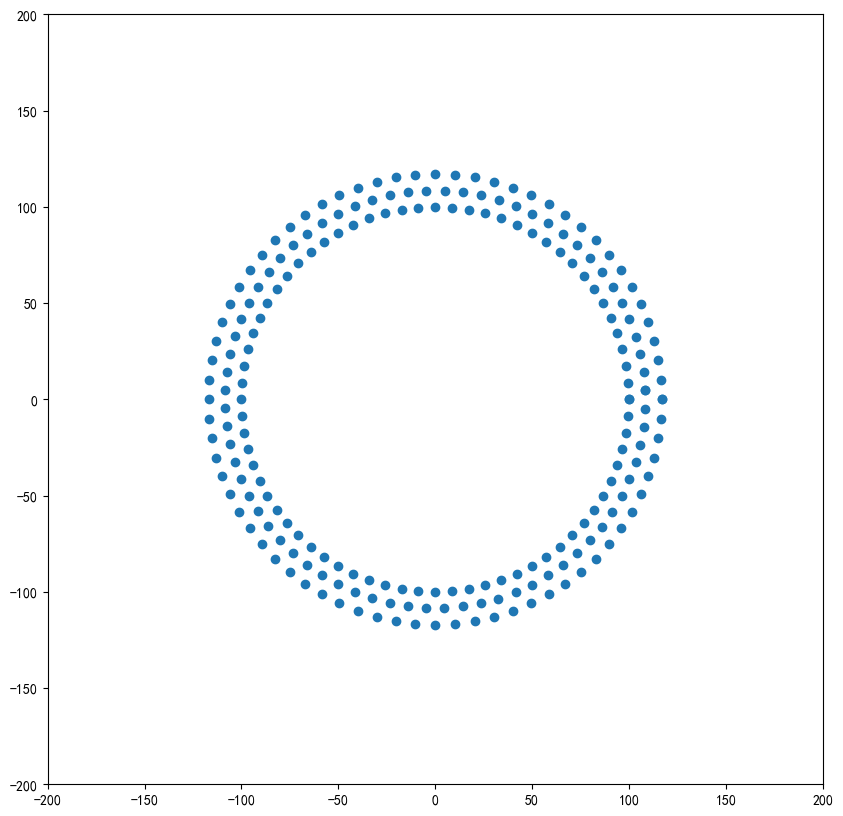

In [95]:
#generate points
x1 = R1*np.cos(circle1)
y1 = R1*np.sin(circle1)
x2 = R12*np.cos(circle2)
y2 = R12*np.sin(circle2)
x3 = R13*np.cos(circle3)
y3 = R13*np.sin(circle3)

x = np.concatenate((x1, x2, x3))
y = np.concatenate((y1, y2, y3))
plt.figure(figsize=(10, 10))
plt.scatter(x, y)
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.show()

6
17


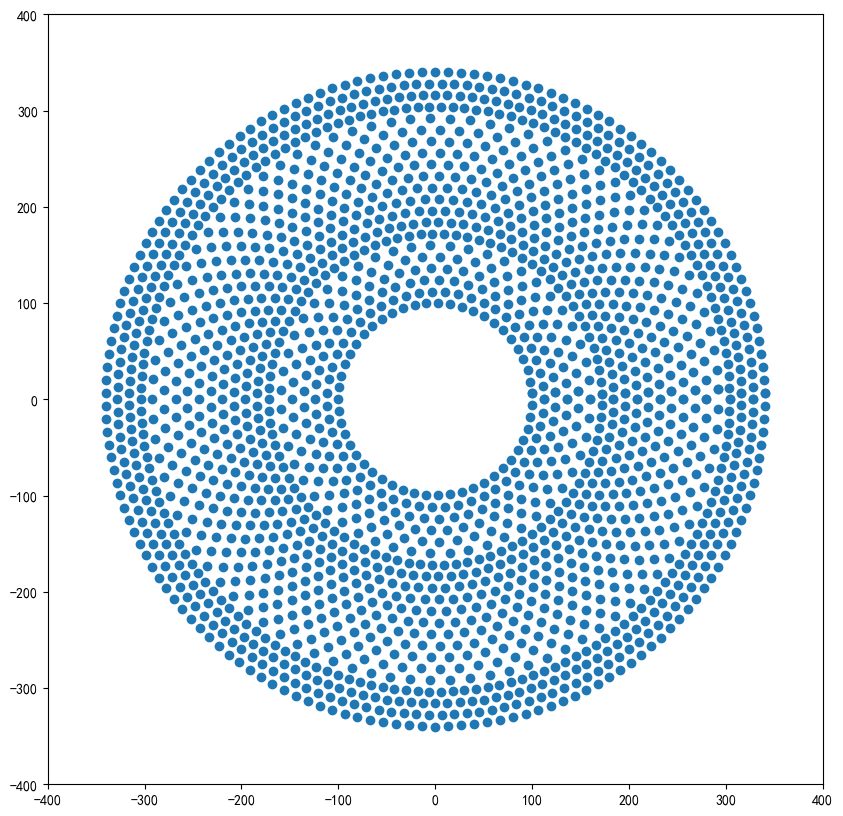

In [63]:
update_ratio = 1.7
min_dist= 12

R = 100
deploy_loop_x = []
deploy_loop_y = []
current_idx = 0
current_main = 0
while current_idx*min_dist + 100 < 350:
    if (current_idx*min_dist + 100)/ (current_main*min_dist + 100) > update_ratio:
        current_main = current_idx
        R = min_dist*current_main+100
        print(current_main)
    k = 2*np.pi*R/min_dist
    k = int(k)
    deg = 2*np.pi/k
    circle = np.linspace(0, 2*np.pi, k)
    if current_idx%2 == 0:
        circle = circle + deg/2
    x = (100+current_idx*min_dist)*np.cos(circle)
    y = (100+current_idx*min_dist)*np.sin(circle)
    deploy_loop_x.append(x)
    deploy_loop_y.append(y)
    current_idx += 1

deploy_loop_x = np.concatenate(deploy_loop_x)
deploy_loop_y = np.concatenate(deploy_loop_y)
plt.figure(figsize=(10, 10))
plt.scatter(deploy_loop_x, deploy_loop_y)
plt.xlim(-400, 400)
plt.ylim(-400, 400)
plt.show()



In [47]:
# output to excel
import pandas as pd
deploy_loop = pd.DataFrame({'x':deploy_loop_x, 'y':deploy_loop_y})
deploy_loop.to_excel('deploy.xlsx', index=False)
print(deploy_loop.shape)

(2409, 2)


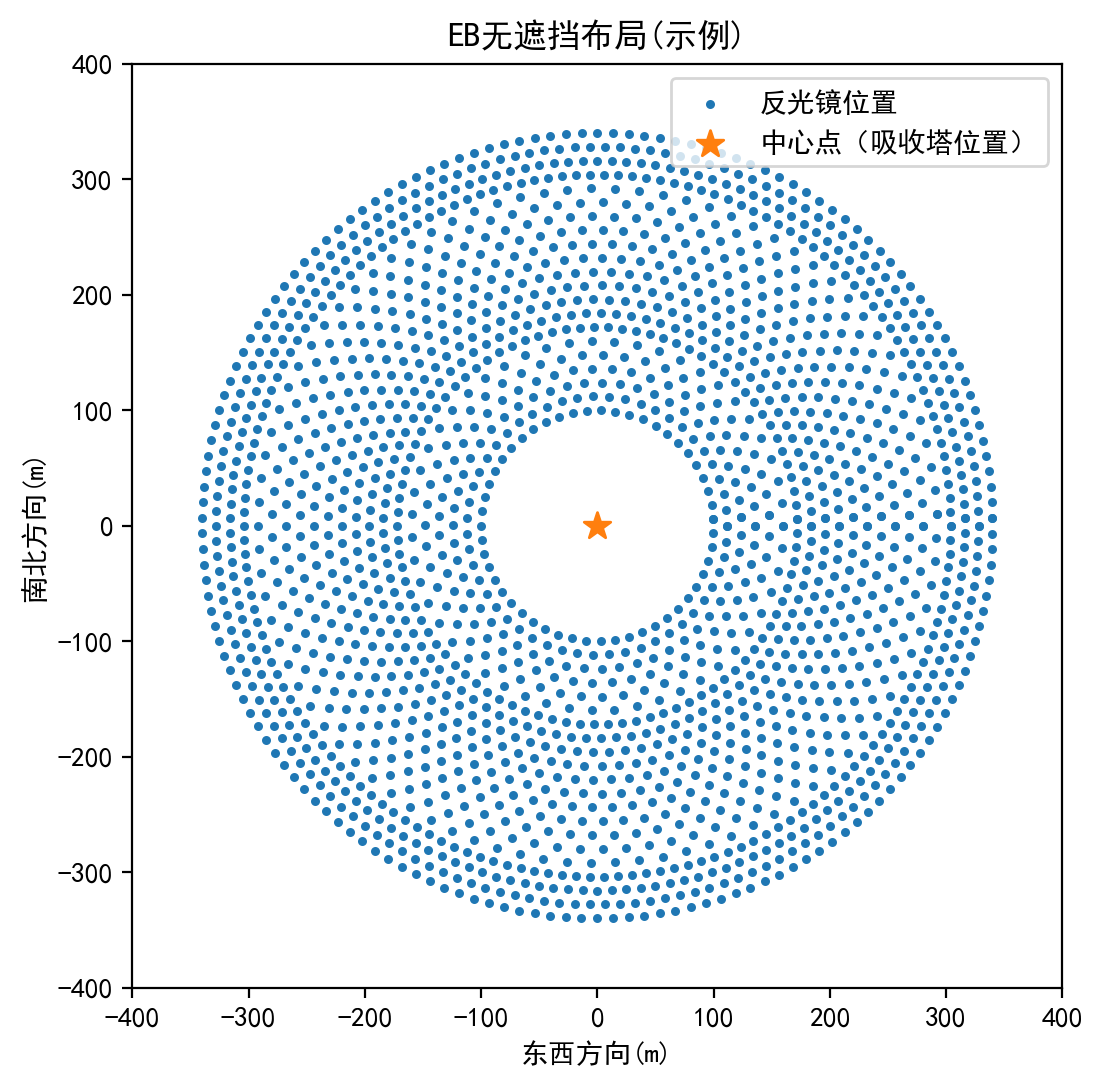

In [65]:
# formal plot
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(6,6), dpi=200)
plt.scatter(deploy_loop_x, deploy_loop_y,s=5,label='反光镜位置')
plt.scatter(0, 0, s=100, marker='*', label='中心点（吸收塔位置）')
plt.xlim(-400, 400)
plt.ylim(-400, 400)
plt.xlabel('东西方向(m)')
plt.ylabel('南北方向(m)')
plt.title('EB无遮挡布局(示例)')
plt.legend()
plt.show()

In [72]:
# read txt as string
import pandas as pd
filename = 'AvsEff.txt'

# 打开文件并逐行读取
with open(filename, 'r') as file:
    lines = file.readlines()

# 初始化变量
h = []
w = []
E_field = []
Avg_E = []

# 遍历每一行
for line in lines:
    # 使用split函数将每一行的内容按空格分隔成列表
    # print(line)
    parts = line.split(' ')
    if parts[0] == 'h:':
        h.append(float(parts[1]))
        w.append(float(parts[3]))
    elif parts[0] == 'E_field:':
        E_field.append(float(parts[1][7:14]))  # 去掉数字中的逗号并转为浮点数
    elif parts[0] == 'Avg_E:':
        Avg_E.append(float(parts[1][7:14]))  # 去掉数字中的逗号并转为浮点数

# 输出提取的信息
print("h:", h)
print("w:", w)
print("E_field:", E_field)
print("Avg_E:", Avg_E)


h: [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.222222222222222, 6.222222222222222, 6.222222222222222, 6.222222222222222, 6.222222222222222, 6.222222222222222, 6.222222222222222, 6.222222222222222, 6.222222222222222, 6.222222222222222, 6.444444444444445, 6.444444444444445, 6.444444444444445, 6.444444444444445, 6.444444444444445, 6.444444444444445, 6.444444444444445, 6.444444444444445, 6.444444444444445, 6.444444444444445, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.888888888888889, 6.888888888888889, 6.888888888888889, 6.888888888888889, 6.888888888888889, 6.888888888888889, 6.888888888888889, 6.888888888888889, 6.888888888888889, 6.888888888888889, 7.111111111111111, 7.111111111111111, 7.111111111111111, 7.111111111111111, 7.111111111111111, 7.111111111111111, 7.111111111111111, 7.111111111111111, 7.111111111111111, 7.1111111111111

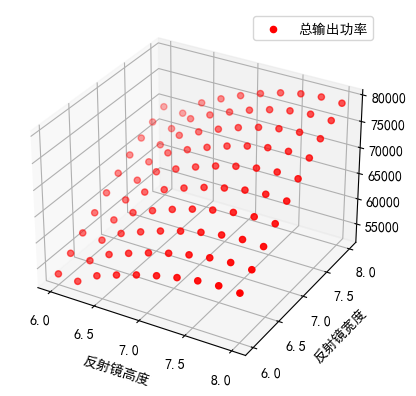

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建一个3D图形对象
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
ax.scatter(h, w, E_field, c='r', label='总输出功率')


# 设置坐标轴标签
ax.set_xlabel('反射镜高度')
ax.set_ylabel('反射镜宽度')

# 添加图例
ax.legend()

# 显示图形
plt.show()


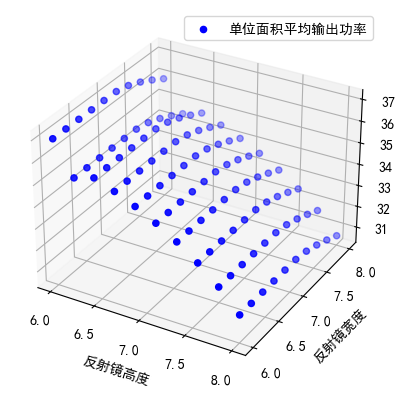

In [92]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建一个3D图形对象
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
ax.scatter(h, w, Avg_E, c='b', label='单位面积平均输出功率')


# 设置坐标轴标签
ax.set_xlabel('反射镜高度')
ax.set_ylabel('反射镜宽度')


# 添加图例
ax.legend()

# 显示图形
plt.show()